### Cài đặt thư viện ###

In [1]:
!pip install pandas matplotlib seaborn wordcloud nltk transformers torch vncorenlp scikit-learn

In [2]:
!pip install underthesea

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
# Xử lý văn bản
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# PhoBERT và PyTorch
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel

# VNCoreNLP 
import vncorenlp
# Thư viện hỗ trợ đánh giá mô hình
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

In [2]:
file_path = "C:\\Users\\HP\\Viettel Crawl\\HKDN_Viettel_NhiemVuBoSung\\Crawl\\data\\Viettel_reviews_crawldata.csv"
df = pd.read_csv(file_path)
df.head()

,Review Name,Review Text,Review Time,Rating
0,Ngọc Như,Nay mình giao dịch lúc 15h ở cửa hàng Trần Phú...,4 tuần trước,1 sao
1,Sơn Tùng Dương,"Toà nhà to đẹp, sạch sẽ thoáng mát",2 tháng trước,5 sao
2,Triết Tử,dịch vụ rất thân thiện nhiệt tình .nhân viên l...,3 tuần trước,5 sao
3,Nguyễn Tấn Tài,"Viettel là một mạng mạnh, tốc độ ổn định cao v...",một tháng trước,5 sao
4,Nguy Quoc Thai B1602823,"Nhân viên chưa có chuyên môn, không nghiêm túc...",3 tháng trước,1 sao


### Kiểm tra dữ liệu bị thiếu ###

In [3]:
df.shape

(188, 4)

In [4]:
# Get basic info
df.info()

# Check for missing values
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Review Name  188 non-null    object
 1   Review Text  94 non-null     object
 2   Review Time  188 non-null    object
 3   Rating       188 non-null    object
dtypes: object(4)
memory usage: 6.0+ KB


Review Name     0
Review Text    94
Review Time     0
Rating          0
dtype: int64

In [5]:
def convert_rating_to_sentiment(rating):
    if "1 sao" in rating or "2 sao" in rating:
        return 0  
    elif "4 sao" in rating or "5 sao" in rating:
        return 1  
    else:
        return None
df['Sentiment'] = df['Rating'].apply(convert_rating_to_sentiment)
df = df.dropna(subset=['Sentiment','Review Text'])
df[['Review Text', 'Rating', 'Sentiment']].head()

,Review Text,Rating,Sentiment
0,Nay mình giao dịch lúc 15h ở cửa hàng Trần Phú...,1 sao,0.0
1,"Toà nhà to đẹp, sạch sẽ thoáng mát",5 sao,1.0
2,dịch vụ rất thân thiện nhiệt tình .nhân viên l...,5 sao,1.0
3,"Viettel là một mạng mạnh, tốc độ ổn định cao v...",5 sao,1.0
4,"Nhân viên chưa có chuyên môn, không nghiêm túc...",1 sao,0.0


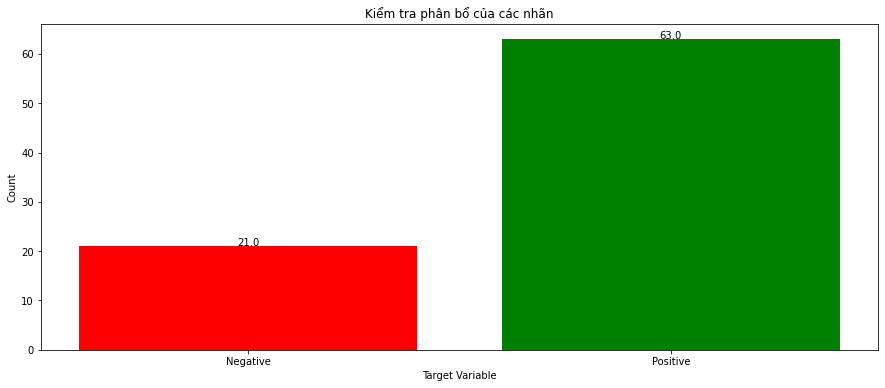

In [6]:
positive_count = df['Sentiment'].sum()
negative_count = len(df) - positive_count

# Tạo bar chart
plt.figure(figsize=(15, 6))
plt.bar(['Negative', 'Positive'], [negative_count, positive_count], color=['red', 'green'])
plt.title('Kiểm tra phân bổ của các nhãn')
plt.xlabel('Target Variable')
plt.ylabel('Count')

for i, count in enumerate([negative_count, positive_count]):
    plt.text(i, count + 0.1, str(count), ha='center')

plt.show()

### EDA và Wordcloud ###

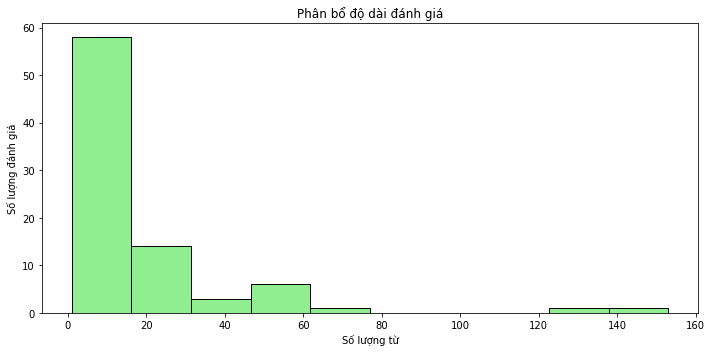

(0,
 5.0    54
 1.0    19
 4.0     9
 2.0     2
 Name: Rating_Numeric, dtype: int64,
 count     84.000000
 mean      17.285714
 std       24.339750
 min        1.000000
 25%        4.000000
 50%        8.000000
 75%       20.250000
 max      153.000000
 Name: Review_Text_Length, dtype: float64)

In [7]:
df['Rating_Numeric'] = df['Rating'].str.extract('(\d)').astype(float)

df['Review_Text_Length'] = df['Review Text'].fillna('').apply(lambda x: len(x.split()))
rating_distribution = df['Rating_Numeric'].value_counts()
review_length_distribution = df['Review_Text_Length'].describe()
missing_reviews_count = df['Review Text'].isna().sum()

plt.figure(figsize=(10, 5))
plt.hist(df['Review_Text_Length'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Phân bổ độ dài đánh giá')
plt.xlabel('Số lượng từ')
plt.ylabel('Số lượng đánh giá')

plt.tight_layout()
plt.show()

missing_reviews_count, rating_distribution, review_length_distribution

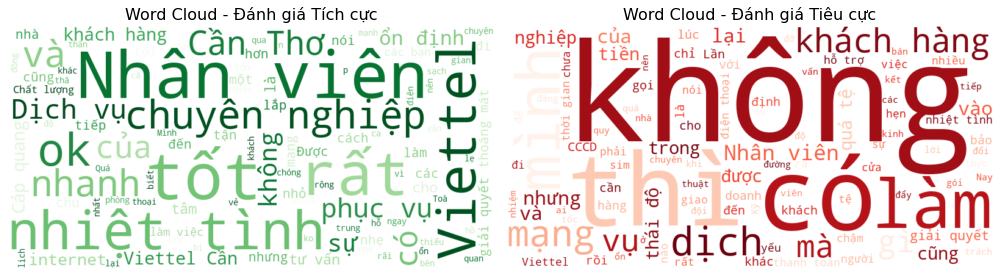

In [8]:
positive_reviews = df[df['Rating_Numeric'] >= 4]['Review Text'].dropna().str.cat(sep=' ')
negative_reviews = df[df['Rating_Numeric'] <= 2]['Review Text'].dropna().str.cat(sep=' ')
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens', max_words=100).generate(positive_reviews)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds', max_words=100).generate(negative_reviews)

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Đánh giá Tích cực', fontsize=16)

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Đánh giá Tiêu cực', fontsize=16)

plt.tight_layout()
plt.show()

### Tiền xử lý dữ liệu cho thuật toán Machine Learning ###

In [12]:
import re
import string
from underthesea import word_tokenize

stopwords_file_path = "C:\\Users\\HP\\Viettel Crawl\\HKDN_Viettel_NhiemVuBoSung\\Crawl\\vietnamese-stopwords.txt"
with open(stopwords_file_path, 'r', encoding='utf-8') as f:
    vietnamese_stopwords = f.read().splitlines()

def preprocess_text(text):
    # Chuyển văn bản thành chữ thường
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'<[^<>]+>', ' ', text)
    text = re.sub(r'[\d{}]+'.format(re.escape(string.punctuation)), ' ', text)

    # Loại bỏ khoảng trắng thừa
    text = " ".join(text.split())

    # Tokenize văn bản sử dụng underthesea
    tokens = word_tokenize(text)

    # Loại bỏ các từ dừng
    filtered_tokens = [word for word in tokens if word.lower() not in vietnamese_stopwords]

    # Kết hợp lại các từ đã lọc thành chuỗi
    return " ".join(filtered_tokens)

df['Processed_Review_Text'] = df['Review Text'].fillna('').apply(preprocess_text)
df[['Review Text', 'Processed_Review_Text']].head()

,Review Text,Processed_Review_Text
0,Nay mình giao dịch lúc 15h ở cửa hàng Trần Phú...,giao dịch h cửa hàng trần phú cửa hàng vắng ta...
1,"Toà nhà to đẹp, sạch sẽ thoáng mát",tòa to đẹp sạch sẽ thoáng mát
2,dịch vụ rất thân thiện nhiệt tình .nhân viên l...,dịch vụ thân thiện nhiệt tình nhân viên tối đi...
3,"Viettel là một mạng mạnh, tốc độ ổn định cao v...",viettel mạng tốc độ ổn định nhân viên giải quy...
4,"Nhân viên chưa có chuyên môn, không nghiêm túc...",nhân viên chuyên môn nghiêm túc khách hàng


## Mô hình Machine Learning ##


In [31]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

X = df['Processed_Review_Text']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Mô hình Multinomial Naive Bayes

In [14]:
# Tạo pipeline với TfidfVectorizer và SMOTE
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('smote', SMOTE(random_state=42)),
    ('nb', MultinomialNB())  # Multinomial Naive Bayes
])

# Định nghĩa grid search với các siêu tham số của MultinomialNB
param_grid_nb = {
    'nb__alpha': [0.1, 0.5, 1.0, 2.0, 5.0]
}

# Sử dụng GridSearchCV để tìm kiếm các tham số tối ưu
grid_search_nb = GridSearchCV(pipeline_nb, param_grid_nb, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_search_nb.fit(X_train, y_train)

# Trích xuất mô hình tốt nhất từ kết quả GridSearchCV
best_nb_model = grid_search_nb.best_estimator_
y_pred_nb = best_nb_model.predict(X_test)

# In ra kết quả
print("Best Parameters found by GridSearchCV:", grid_search_nb.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters found by GridSearchCV: {'nb__alpha': 0.5}
Accuracy: 0.6470588235294118

Classification Report:
               precision    recall  f1-score   support

         0.0       0.29      0.67      0.40         3
         1.0       0.90      0.64      0.75        14

    accuracy                           0.65        17
   macro avg       0.59      0.65      0.57        17
weighted avg       0.79      0.65      0.69        17



In [15]:
best_nb_model

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('smote', SMOTE(random_state=42)),
                ('nb', MultinomialNB(alpha=0.5))])

### Mô hình Logictis Regression

In [16]:
# Tạo pipeline với TfidfVectorizer và SMOTE
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('smote', SMOTE(random_state=42)),
    ('lr', LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000))  # Thêm class_weight='balanced' và tăng số lần lặp
])

# Định nghĩa grid search với các siêu tham số của Logistic Regression
param_grid_lr = {
    'lr__C': [0.01, 0.1, 1, 10, 100],  # Điều chỉnh tham số regularization
    'lr__penalty': ['l1', 'l2'],  # Thử nghiệm với các loại regularization khác nhau
    'lr__solver': ['liblinear', 'saga']  # Chọn solver phù hợp với các penalty
}

# Sử dụng GridSearchCV để tìm kiếm các tham số tối ưu
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_search_lr.fit(X_train, y_train)

# Trích xuất mô hình tốt nhất từ kết quả GridSearchCV
best_lr_model = grid_search_lr.best_estimator_
y_pred_lr = best_lr_model.predict(X_test)

# In ra kết quả
print("Best Parameters found by GridSearchCV:", grid_search_lr.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters found by GridSearchCV: {'lr__C': 100, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Accuracy: 0.8823529411764706

Classification Report:
               precision    recall  f1-score   support

         0.0       0.67      0.67      0.67         3
         1.0       0.93      0.93      0.93        14

    accuracy                           0.88        17
   macro avg       0.80      0.80      0.80        17
weighted avg       0.88      0.88      0.88        17



In [17]:
best_lr_model

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('smote', SMOTE(random_state=42)),
                ('lr',
                 LogisticRegression(C=100, class_weight='balanced',
                                    max_iter=1000, penalty='l1',
                                    random_state=42, solver='liblinear'))])

### Mô hình Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

param_grid_rf = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

best_rf_model = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)

print("Best Parameters found by GridSearchCV:", grid_search_rf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters found by GridSearchCV: {'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Accuracy: 0.9411764705882353

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.67      0.80         3
         1.0       0.93      1.00      0.97        14

    accuracy                           0.94        17
   macro avg       0.97      0.83      0.88        17
weighted avg       0.95      0.94      0.94        17



In [19]:
best_rf_model

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000)),
                ('smote', SMOTE(random_state=42)),
                ('rf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [32]:
import pickle
with open("best_rf_model.pkl", "wb") as model_file:
    pickle.dump(best_rf_model, model_file)

In [48]:
def RF_predict(input_text):
    with open("best_rf_model.pkl", "rb") as model_file:
        best_rf_model = pickle.load(model_file)
    processed_review = preprocess_text(input_text)
    predicted_class = best_rf_model.predict([processed_review])[0]
    sentiment = "tích cực" if predicted_class == 1 else "tiêu cực"
    return sentiment

In [53]:
RF_predict('Tôi rất hài lòng với các gói cước của Viettel, giá cả hợp lý và chất lượng ổn định.')

'tích cực'

In [54]:
RF_predict('Mạng rất chậm, không dùng nổi, dịch vụ kém')

'tiêu cực'

### PhoBERT Embedding ###

In [20]:
# Load PhoBERT tokenizer and model
phobert_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
phobert_model = AutoModel.from_pretrained("vinai/phobert-base")

# Preprocessing function for PhoBERT
def preprocess_for_bert(text):
    # Chuyển văn bản thành chữ thường
    text = text.lower()
    
    # Loại bỏ các liên kết URL
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    
    # Loại bỏ các thẻ HTML
    text = re.sub(r'<[^<>]+>', ' ', text)
    
    # Loại bỏ các số và dấu câu
    text = re.sub(r'[\d{}]+'.format(re.escape(string.punctuation)), ' ', text)
    
    # Loại bỏ khoảng trắng thừa
    text = " ".join(text.split())
    
    return text

# Embedding function using PhoBERT
def phobert_embedding(text):
    # Tokenize văn bản
    tokens = phobert_tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=256)
    
    # Chuyển văn bản thành embedding
    with torch.no_grad():
        outputs = phobert_model(**tokens)
    
    # Lấy embedding của token CLS (token đầu tiên) làm đại diện
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    
    return cls_embedding

# Áp dụng tiền xử lý cho toàn bộ dữ liệu
df['Processed_Review_Text'] = df['Review Text'].fillna('').apply(preprocess_for_bert)

### Mô hình ML trên  embedding từ PhoBERT ###

### Logictis Regression (PhoBERT) ###

In [21]:
X = df['Processed_Review_Text']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tạo embedding từ PhoBERT cho X_train và X_test
X_train_embeddings = np.array([phobert_embedding(text) for text in X_train])
X_test_embeddings = np.array([phobert_embedding(text) for text in X_test])

# Áp dụng SMOTE để cân bằng tập huấn luyện
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_embeddings, y_train)

# Khởi tạo Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)

# Định nghĩa các siêu tham số cho GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs']  
}

# Sử dụng GridSearchCV để tìm kiếm siêu tham số tốt nhất
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)

# Trích xuất mô hình Logistic Regression tốt nhất
best_LR_model_BERT = grid_search.best_estimator_
y_pred = best_LR_model_BERT.predict(X_test_embeddings)

# In ra kết quả
print("Best Parameters found by GridSearchCV:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters found by GridSearchCV: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.8235294117647058

Classification Report:
               precision    recall  f1-score   support

         0.0       0.50      0.33      0.40         3
         1.0       0.87      0.93      0.90        14

    accuracy                           0.82        17
   macro avg       0.68      0.63      0.65        17
weighted avg       0.80      0.82      0.81        17



In [22]:
best_LR_model_BERT

LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear')

### Random Forrest (PhoBERT) ###

In [23]:
# Khởi tạo Random Forest
rf = RandomForestClassifier(random_state=42)

# Định nghĩa các siêu tham số cho GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # Số lượng cây trong rừng
    'max_depth': [None, 10, 20, 30],  # Độ sâu tối đa của cây
    'min_samples_split': [2, 5, 10],  # Số lượng mẫu tối thiểu để chia một node
    'min_samples_leaf': [1, 2, 4]     # Số lượng mẫu tối thiểu trong mỗi node lá
}

# Sử dụng GridSearchCV để tìm kiếm siêu tham số tốt nhất cho mô hình Random Forest
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_rf.fit(X_train_smote, y_train_smote)

# Trích xuất mô hình Random Forest tốt nhất
best_rf_model_BERT = grid_search_rf.best_estimator_
y_pred_rf = best_rf_model_BERT.predict(X_test_embeddings)

# In ra kết quả
print("Best Parameters found by GridSearchCV:", grid_search_rf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters found by GridSearchCV: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy: 0.8235294117647058

Classification Report:
               precision    recall  f1-score   support

         0.0       0.50      0.33      0.40         3
         1.0       0.87      0.93      0.90        14

    accuracy                           0.82        17
   macro avg       0.68      0.63      0.65        17
weighted avg       0.80      0.82      0.81        17



In [24]:
best_rf_model_BERT

RandomForestClassifier(n_estimators=300, random_state=42)

### So sánh mô hình ###

In [25]:
#NB
y_pred = best_nb_model.predict(X_test)
y_test
metrics_model_nb = [accuracy_score(y_test, y_pred),
                    precision_score(y_test, y_pred),
                    recall_score(y_test, y_pred),
                    f1_score(y_test, y_pred)]

In [26]:
#LR
y_pred = best_lr_model.predict(X_test)
y_test
metrics_model_lr = [accuracy_score(y_test, y_pred),
                    precision_score(y_test, y_pred),
                    recall_score(y_test, y_pred),
                    f1_score(y_test, y_pred)]

In [27]:
#RF
y_pred = best_rf_model.predict(X_test)
y_test
metrics_model_rf = [accuracy_score(y_test, y_pred),
                    precision_score(y_test, y_pred),
                    recall_score(y_test, y_pred),
                    f1_score(y_test, y_pred)]

In [28]:
compare_df = pd.DataFrame({
    'Model': ['Model NB', 'Model LR', 'Model RF'],
    'Accuracy': [metrics_model_nb[0], metrics_model_lr[0], metrics_model_rf[0]],
    'Precision': [metrics_model_nb[1], metrics_model_lr[1], metrics_model_rf[1]],
    'Recall': [metrics_model_nb[2], metrics_model_lr[2], metrics_model_rf[2]],
    'F1-Score': [metrics_model_nb[3], metrics_model_lr[3], metrics_model_rf[3]]
})

# Display
compare_df.groupby('Model').mean().round(2)

,Accuracy,Precision,Recall,F1-Score
Model,,,,
Model LR,0.88,0.93,0.93,0.93
Model NB,0.59,0.82,0.64,0.72
Model RF,0.94,0.93,1.00,0.97
